In [46]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary

In [47]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

continue_train = False

os.makedirs('results', exist_ok=True)
model_path = 'results/model.pth'
optimizer_path = 'results/optimizer.pth'
dataset_path = '../datasets/'

n_epochs = 10
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.001
momentum = 0.9
log_interval = 200

writer = SummaryWriter('logs')

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [48]:
transform = torchvision.transforms.Compose([ 
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(
                    (0.1307,),(0.3081,))
                ])

train_loader = torch.utils.data.DataLoader(
        torchvision.datasets.EMNIST(
            dataset_path,
            split = 'balanced',
            train = True,
            download = True,
            transform = transform),
        batch_size = batch_size_train,
        shuffle = True,
        num_workers=4,
        pin_memory=True)
 
test_loader = torch.utils.data.DataLoader(
        torchvision.datasets.EMNIST(
            dataset_path,
            split = 'balanced',
            train = False,
            download = True,
            transform = transform),
        batch_size = batch_size_test,
        shuffle = True,
        num_workers = 4,
        pin_memory = True)

In [49]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


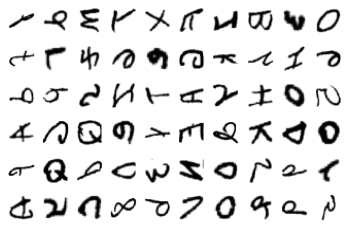

In [50]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [51]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.input_size = 1
        self.hidden_sizes = [50,100,100]
        self.output_size = 47
        
        self.conv1 = nn.Conv2d(self.input_size, self.hidden_sizes[0], kernel_size=5)
        self.conv2 = nn.Conv2d(self.hidden_sizes[0], self.hidden_sizes[1], kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(self.hidden_sizes[1]*4*4, self.hidden_sizes[2])
        self.fc2 = nn.Linear(self.hidden_sizes[2], self.output_size)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [52]:
network = Net()
network.to(device)
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

if continue_train:
    network_state_dict = torch.load(model_path)
    network.load_state_dict(network_state_dict)

    optimizer_state_dict = torch.load(optimizer_path)
    optimizer.load_state_dict(optimizer_state_dict)

In [53]:
summary(network, (batch_size_train, network.input_size, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      --                        --
├─Conv2d: 1-1                            [64, 50, 24, 24]          1,300
├─Conv2d: 1-2                            [64, 100, 8, 8]           125,100
├─Dropout2d: 1-3                         [64, 100, 8, 8]           --
├─Linear: 1-4                            [64, 100]                 160,100
├─Linear: 1-5                            [64, 47]                  4,747
Total params: 291,247
Trainable params: 291,247
Non-trainable params: 0
Total mult-adds (M): 570.88
Input size (MB): 0.20
Forward/backward pass size (MB): 18.10
Params size (MB): 1.16
Estimated Total Size (MB): 19.46


Layer (type:depth-idx)                   Output Shape              Param #
Net                                      --                        --
├─Conv2d: 1-1                            [64, 50, 24, 24]          1,300
├─Conv2d: 1-2                            [64, 100, 8, 8]           125,100
├─Dropout2d: 1-3                         [64, 100, 8, 8]           --
├─Linear: 1-4                            [64, 100]                 160,100
├─Linear: 1-5                            [64, 47]                  4,747
Total params: 291,247
Trainable params: 291,247
Non-trainable params: 0
Total mult-adds (M): 570.88
Input size (MB): 0.20
Forward/backward pass size (MB): 18.10
Params size (MB): 1.16
Estimated Total Size (MB): 19.46

In [54]:
def train(epoch):
    running_loss = 0.0
    network.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = network(images)
        loss = F.nll_loss(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % log_interval == 0:
            step = (i+1) * epoch + (epoch-1) *len(train_loader)
            writer.add_scalar('Loss/train', loss.item(), step)
            
            j = i * len(images)
            k = round(100. * i / len(train_loader))

            print(f'Train Epoch: {epoch} [{j}/{len(train_loader.dataset)} ({k}%)]\tLoss: {round(loss.item(), 4)}')

    torch.save(network.state_dict(), model_path)
    torch.save(optimizer.state_dict(), optimizer_path)
    return output

In [55]:
def test(epoch):
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            output = network(images)
            test_loss += F.nll_loss(output, labels, reduction='sum').item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(labels.data.view_as(pred)).sum()
    
            if i % log_interval == 0:
                step = (i+1) * epoch + (epoch-1) *len(test_loader)
                writer.add_scalar('Loss/test', test_loss / len(test_loader.dataset), step)
                
    test_loss /= len(test_loader.dataset)
        
    test_accuracy = 100. * correct / len(test_loader.dataset)
    test_accuracy = int(test_accuracy)
    writer.add_scalar('Accuracy/test', test_accuracy, epoch)
    print(f'\nTest set: Avg. loss: {round(test_loss, 4)}, Accuracy: {correct}/{len(test_loader.dataset)} ({round(test_accuracy)}%)\n')

In [56]:
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test(epoch)
writer.close()

Train Epoch: 1 [0/112800 (0%)]	Loss: 3.8589
Train Epoch: 1 [12800/112800 (11%)]	Loss: 3.7349
Train Epoch: 1 [25600/112800 (23%)]	Loss: 2.9777
Train Epoch: 1 [38400/112800 (34%)]	Loss: 2.6331
Train Epoch: 1 [51200/112800 (45%)]	Loss: 2.147
Train Epoch: 1 [64000/112800 (57%)]	Loss: 1.8474
Train Epoch: 1 [76800/112800 (68%)]	Loss: 1.7018
Train Epoch: 1 [89600/112800 (79%)]	Loss: 1.4213
Train Epoch: 1 [102400/112800 (91%)]	Loss: 1.3832

Test set: Avg. loss: 0.8981, Accuracy: 13787/18800 (73%)

Train Epoch: 2 [0/112800 (0%)]	Loss: 1.296
Train Epoch: 2 [12800/112800 (11%)]	Loss: 1.395
Train Epoch: 2 [25600/112800 (23%)]	Loss: 1.1019
Train Epoch: 2 [38400/112800 (34%)]	Loss: 1.0336
Train Epoch: 2 [51200/112800 (45%)]	Loss: 1.2785
Train Epoch: 2 [64000/112800 (57%)]	Loss: 0.7619
Train Epoch: 2 [76800/112800 (68%)]	Loss: 1.4578
Train Epoch: 2 [89600/112800 (79%)]	Loss: 0.9843
Train Epoch: 2 [102400/112800 (91%)]	Loss: 0.7535

Test set: Avg. loss: 0.6526, Accuracy: 14918/18800 (79%)

Train Epoch